In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as tgrad
from sklearn.model_selection import train_test_split

import os
import time
import numpy as np
import pandas as pd


import utils
import networks
import matplotlib.pyplot as plt

import importlib

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# Data Sampling
Here in our case, the system is European Call Option PDE and the physical information about the system consists of Boundary Value conditions, final Value conditions and the PDE itself.

In [3]:
K = 10
r = 0.035
sigma = 0.2
T = 1
S_range = [0, int(5*K)]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
M = 100
N = 5000

# Build Neural Network

In [4]:
pinn = networks.FeedforwardNeuralNetwork(2, 50, 1, 8)
pinn.cuda()

FeedforwardNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-7): 7 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

In [5]:
import torchimize
from torchimize.functions import lsq_lma
n_epochs = 5000
lossFunction = nn.MSELoss()

# coeffs_list = lsq_lma(fnn.parameters(), function=lossFunction)
optimizer = optim.Adam(pinn.parameters(), lr=0.00003)

In [6]:
# physical loss samples
samples = {"pde": 5000, "bc":500, "fc":500}

# sample data generated by finite difference method
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = utils.fdm_data(S_range[-1], T, M, N, "500000sample.csv", device)

# Modelling

- For each iteration in the training loop, we are sampling data for the three physical conditions of the PDE.
- Then we are calculating the loss three times on the same model, accumulating them into a combined objective function to be minimised for the Neural Network.
- The first loss is the differential equation loss. Here we are trying to minimise the PDE by calculating gradients and forming the PDE itself.
- The remaining losses are calculated for boundary value and initial value conditions for the PDE.
- Mean Squared Error loss function `nn.MSELoss()` is chosen as the criterion to be minimised and 
- Adam optimizer `nn.optim.Adam(lr=3e-5)` with a learning rate of 0.00003 is chosen for performing the weight updates.

In [7]:
loss_hist = []
start_time = time.time()

for epoch in range(n_epochs):
    
    bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, r, sigma, T, S_range[-1], S_range, t_range, gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)
    # save training data points to tensor and send to device
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(n_v_train).float().to(device)
    
    bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
    bc_v_train = torch.from_numpy(bc_v_train).float().to(device)
    
    
    # PDE Round
    y1_hat = pinn(n_st_train)
    grads = tgrad.grad(y1_hat, n_st_train, grad_outputs=torch.ones(y1_hat.shape).cuda(), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = n_st_train[:, 1].view(-1, 1)
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)
    
    # conditions Round
    y2_hat = pinn(bc_st_train)
    bc_loss = lossFunction(bc_v_train, y2_hat)
    
    # data Round
    y3_hat = pinn(X_train_tensor)
    data_loss = lossFunction(y_train_tensor, y3_hat)
    
    # Backpropagation and Update
    optimizer.zero_grad()
    mse_loss = pde_loss + bc_loss + data_loss
    mse_loss.backward()
    optimizer.step()
    
    loss_hist.append(mse_loss.item())
    if epoch % 500 == 0:
        print(f'{epoch}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, data loss: {data_loss.item():.5f}, total loss: {mse_loss.item():5f}, minimum loss: {min(loss_hist):.5f}')

end_time = time.time()
print('run time:', end_time - start_time)

0/5000 PDE Loss: 0.00002, BC Loss: 678.89709, data loss: 427.73892, total loss: 1106.635986, minimum loss: 1106.63599
500/5000 PDE Loss: 0.00679, BC Loss: 102.23629, data loss: 54.36722, total loss: 156.610291, minimum loss: 156.61029
1000/5000 PDE Loss: 0.00119, BC Loss: 5.85438, data loss: 10.84250, total loss: 16.698074, minimum loss: 16.69807
1500/5000 PDE Loss: 0.06715, BC Loss: 1.42166, data loss: 2.74770, total loss: 4.236507, minimum loss: 4.23651
2000/5000 PDE Loss: 0.00118, BC Loss: 0.00199, data loss: 0.00330, total loss: 0.006468, minimum loss: 0.00647
2500/5000 PDE Loss: 0.00003, BC Loss: 0.00090, data loss: 0.00199, total loss: 0.002921, minimum loss: 0.00292
3000/5000 PDE Loss: 0.00005, BC Loss: 0.00120, data loss: 0.00165, total loss: 0.002905, minimum loss: 0.00273
3500/5000 PDE Loss: 0.00008, BC Loss: 0.00111, data loss: 0.00152, total loss: 0.002711, minimum loss: 0.00268
4000/5000 PDE Loss: 0.00011, BC Loss: 0.00106, data loss: 0.00150, total loss: 0.002676, minimum

Text(0.5, 1.0, 'PINN')

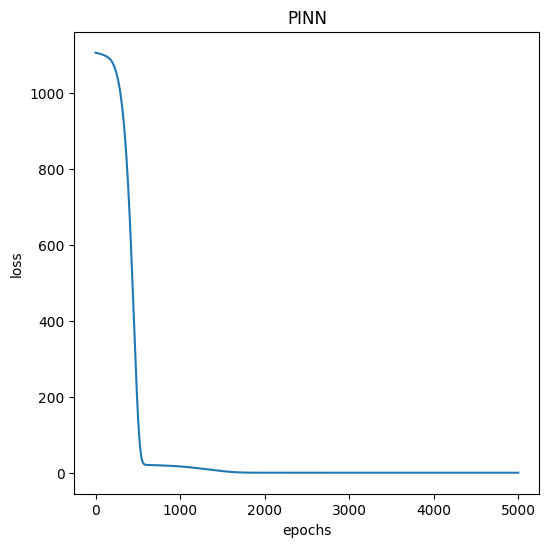

In [8]:
fig = plt.figure(figsize=(6,6))
plt.plot(range(n_epochs), loss_hist)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('PINN')

In [9]:
# Evaluate the model on the test set
pinn.eval()
with torch.no_grad():
    test_outputs = pinn(X_test_tensor)
    test_loss = lossFunction(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0015
